In [1]:
%load_ext memory_profiler

import numpy as np

import scipy
import scipy.sparse as sparse
import scipy.io as io

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import f1_score, silhouette_score, silhouette_samples

from openTSNE import TSNE

# Load data

In [2]:
mtx = io.mmread('/data01/hanbin973/fastrna_paper/datasets/pbmc_ssc/mat.mtx').astype(np.float32).tocsc()
meta = pd.read_csv('/data01/hanbin973/fastrna_paper/datasets/pbmc_ssc/meta.csv', index_col=0)

# FastRNA

In [3]:
from fastrna.mkl_funcs import *
from fastrna.utils import *
from fastrna.core import fastrna_hvg, fastrna_pca

In [4]:
# sort data by batch
batch_label = pd.factorize(meta.Method)[0]
idx_reorder = batch_label.argsort()
blab_reorder = batch_label[idx_reorder]
ct_reorder = meta.CellType.values[idx_reorder]
mtx_reorder = mtx[:,idx_reorder]

In [5]:
%time gene_vars = fastrna_hvg(mtx_reorder, blab_reorder)
gene_order_var = gene_vars.argsort()[::-1]
mtx_hvg = mtx_reorder[gene_order_var[:3000],:] 
mtx_hvg.sort_indices()
numi = np.asarray(mtx_reorder.sum(axis=0)).ravel()
%time eig_val, eig_vec, pca, rrt = fastrna_pca(mtx_hvg, numi, blab_reorder)
name = 'pbmcssc'
pd.DataFrame(pca).to_csv('pca_coord/%s/pca_fr.csv' % name)

CPU times: user 1.07 s, sys: 48.8 ms, total: 1.12 s
Wall time: 78.4 ms
CPU times: user 15.6 s, sys: 1.07 s, total: 16.7 s
Wall time: 661 ms


# Scanpy

In [6]:
adata = sc.AnnData(mtx.T)
%time %memit sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=3000)
adata_fs = adata[:, adata.var["highly_variable"]]
%time %memit sc.experimental.pp.normalize_pearson_residuals(adata_fs)
%time %memit sc.pp.pca(adata_fs, n_comps=50)
pd.DataFrame(adata_fs.obsm['X_pca']).to_csv('pca_coord/%s/pca_ap.csv' % name)

peak memory: 863.93 MiB, increment: 337.07 MiB
CPU times: user 2.81 s, sys: 1.89 s, total: 4.7 s
Wall time: 4.83 s


/home/hanbin973/anaconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/experimental/pp/_normalization.py:123: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


peak memory: 996.05 MiB, increment: 427.11 MiB
CPU times: user 487 ms, sys: 289 ms, total: 777 ms
Wall time: 897 ms
peak memory: 1113.45 MiB, increment: 424.73 MiB
CPU times: user 47.8 s, sys: 11.5 s, total: 59.3 s
Wall time: 1.7 s


# Benchmark

In [7]:
name = 'pbmcssc'
pca_logpca = pd.read_csv('../fastrna_r/pca_coord/%s/pca_log.csv' % name, index_col=0).values[idx_reorder,:]
pca_sct = pd.read_csv('../fastrna_r/pca_coord/%s/pca_sct.csv' % name, index_col=0).values[idx_reorder,:]
pca_harmony = pd.read_csv('../fastrna_r/pca_coord/%s/pca_harmony.csv' % name, index_col=0).values[idx_reorder,:]
pca_glmpca = pd.read_csv('../fastrna_r/pca_coord/%s/pca_glmpca.csv' % name, index_col=0).values[idx_reorder,:]
pca_ap = pd.read_csv('pca_coord/%s/pca_ap.csv' % name, index_col=0).values[idx_reorder,:]
pca_fr = pd.read_csv('pca_coord/%s/pca_fr.csv' % name, index_col=0).values

In [8]:
sils = []
Xs = [pca_logpca[:,:50], pca_sct[:,:50], pca_harmony[:,:50], pca_glmpca[:,:50], pca_ap[:,:50], pca_fr[:,:50]]
labels = [ct_reorder] * len(Xs)

for X, lab in zip(Xs, labels):
    sils.append(silhouette_samples(X, lab, metric='cosine'))
sils

[array([0.33055091, 0.86525991, 0.9132696 , ..., 0.51490003, 0.69113954,
        0.23448893]),
 array([0.52768018, 0.78816985, 0.81238417, ..., 0.52154125, 0.56872614,
        0.19181529]),
 array([0.14119694, 0.64520528, 0.73742863, ..., 0.32512533, 0.48641394,
        0.14779793]),
 array([ 0.30854299,  0.69480873,  0.69610023, ...,  0.30612455,
         0.61173481, -0.02397044]),
 array([0.51623879, 0.89138094, 0.89258109, ..., 0.59252337, 0.50075174,
        0.06654428]),
 array([ 0.56437638,  0.89607748,  0.91107372, ...,  0.70093142,
         0.44304004, -0.06648939])]

In [9]:
scores =[]
for X, lab in zip(Xs, labels):
    labels = pd.factorize(lab)[0]
    k=5
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, labels, cv=5, scoring='accuracy')
    scores.append(score)
    
scores

[array([0.90825688, 0.91330954, 0.87302397, 0.93523712, 0.86588475]),
 array([0.91845056, 0.92248853, 0.91330954, 0.94696583, 0.93115757]),
 array([0.90519878, 0.92299847, 0.90056094, 0.92962774, 0.88526262]),
 array([0.91590214, 0.92401836, 0.90770015, 0.93778684, 0.94084651]),
 array([0.91692151, 0.92401836, 0.90464049, 0.93778684, 0.93523712]),
 array([0.88583078, 0.90668027, 0.88169301, 0.9245283 , 0.92401836])]

In [10]:
sils_b = []
Xs = [pca_logpca[:,:50], pca_sct[:,:50], pca_harmony[:,:50], pca_glmpca[:,:50], pca_ap[:,:50], pca_fr[:,:50]]
labels = [blab_reorder] * len(Xs)
for X, lab in zip(Xs, labels):
    sils_b.append(silhouette_samples(X, lab, metric='cosine'))
sils_b

[array([ 0.01179854,  0.02319228,  0.0134526 , ..., -0.00718658,
         0.11266657, -0.16315855]),
 array([ 0.09917757,  0.07911743,  0.06368265, ...,  0.00348604,
         0.24017202, -0.1110354 ]),
 array([ 0.0355237 ,  0.03522577,  0.03598365, ..., -0.04524428,
         0.09223499, -0.11893761]),
 array([-0.01543986, -0.01024079, -0.01914323, ...,  0.01179285,
         0.00709812, -0.07785528]),
 array([ 0.11087168,  0.06127973,  0.06182741, ...,  0.00662096,
         0.26392875, -0.08112067]),
 array([ 0.02398109,  0.01821788,  0.02285595, ..., -0.0520076 ,
         0.03295162, -0.08060307])]

In [11]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

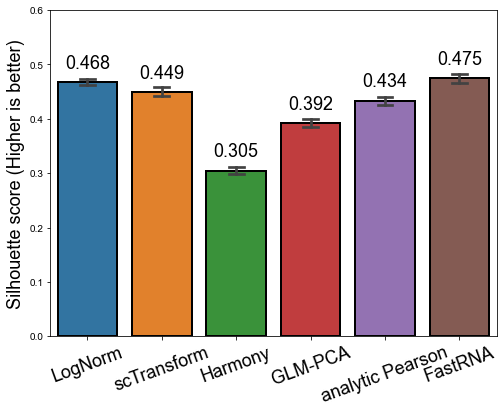

In [12]:
df = pd.DataFrame(np.array(sils).T, columns=['LogNorm', 
                                               'scTransform',
                                               'Harmony',
                                               'GLM-PCA',
                                               'analytic Pearson',
                                               'FastRNA'])
df_melt = pd.melt(df, var_name='Method', value_name='Silhouette score')        

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='Method', y='Silhouette score', data=df_melt, ax=ax,
           edgecolor='black', linewidth=2, capsize=.2, estimator=np.median)

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, rotation=20)

ax.set_ylabel(ax.get_ylabel() + ' (Higher is better)', fontsize=18)

ax.bar_label(ax.containers[0], fontsize=18, padding=10, fmt='%.3f')
ax.set_ylim([0,0.6])
ax.set_title('', fontsize=18, va='bottom')
ax.set_xlabel('')

plt.show()

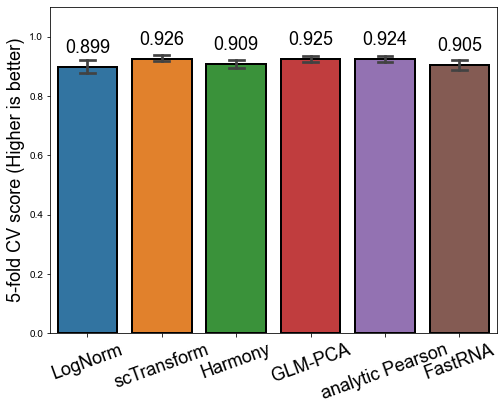

In [13]:
df = pd.DataFrame(np.array(scores).T, columns=['LogNorm', 
                                               'scTransform',
                                               'Harmony',
                                               'GLM-PCA',
                                               'analytic Pearson',
                                               'FastRNA'])
df_melt = pd.melt(df, var_name='Method', value_name='5-fold CV score')        

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='Method', y='5-fold CV score', data=df_melt, ax=ax,
           edgecolor='black', linewidth=2, capsize=.2)

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, rotation=20)

ax.set_ylabel(ax.get_ylabel() + ' (Higher is better)', fontsize=18)

ax.bar_label(ax.containers[0], fontsize=18, padding=10, fmt='%.3f')
ax.set_ylim([0,1.1])
ax.set_title('', fontsize=18, va='bottom')
ax.set_xlabel('')

plt.show()

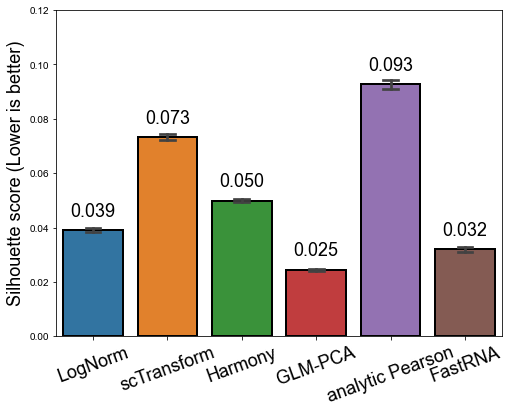

In [14]:
df = pd.DataFrame(np.abs(np.array(sils_b).T), columns=['LogNorm', 
                                               'scTransform',
                                               'Harmony',
                                               'GLM-PCA',
                                               'analytic Pearson',
                                               'FastRNA'])
df_melt = pd.melt(df, var_name='Method', value_name='Silhouette score')        

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='Method', y='Silhouette score', data=df_melt, ax=ax,
           edgecolor='black', linewidth=2, capsize=.2, estimator=np.median)

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, rotation=20)

ax.set_ylabel(ax.get_ylabel() + ' (Lower is better)', fontsize=18)

ax.bar_label(ax.containers[0], fontsize=18, padding=10, fmt='%.3f')
ax.set_ylim([0,0.12])
ax.set_title('', fontsize=18, va='bottom')
ax.set_xlabel('')

plt.show()

In [15]:
def tsne_for_pca(pca):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6.5))
    np.random.seed(0)
    tsne = TSNE(n_jobs=16, perplexity=30, exaggeration=2, initialization=pca[:,:2]).fit(pca[:,:])

    scatter = sns.scatterplot(x=tsne[:,0], y=tsne[:,1], 
                    s=5, 
                    hue=ct_reorder, 
                    edgecolor='none', 
                    legend=True,
                    ax=ax[0],
                    palette='tab10',
                    )
    sns.scatterplot(x=tsne[:,0], y=tsne[:,1], 
                    s=5, 
                    hue=blab_reorder, 
                    edgecolor='none', 
                    legend=False,
                    ax=ax[1],
                    palette='cividis'
                    )

    ax[0].legend().set_visible(False)

    handles0, labels0 = ax[0].get_legend_handles_labels()
    legend = fig.legend(handles0, 
               labels0, 
               bbox_to_anchor=(0.5,0.05), 
               loc='upper center', 
               ncol=2, 
               fontsize=18, 
               frameon=False)

    legend.set_title('Cell-types', prop={'size':20})

    ax[0].set_title('Colored-by-celltype', fontsize=15)
    ax[1].set_title('Colored-by-batch', fontsize=15)


    plt.show()
    return tsne

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.


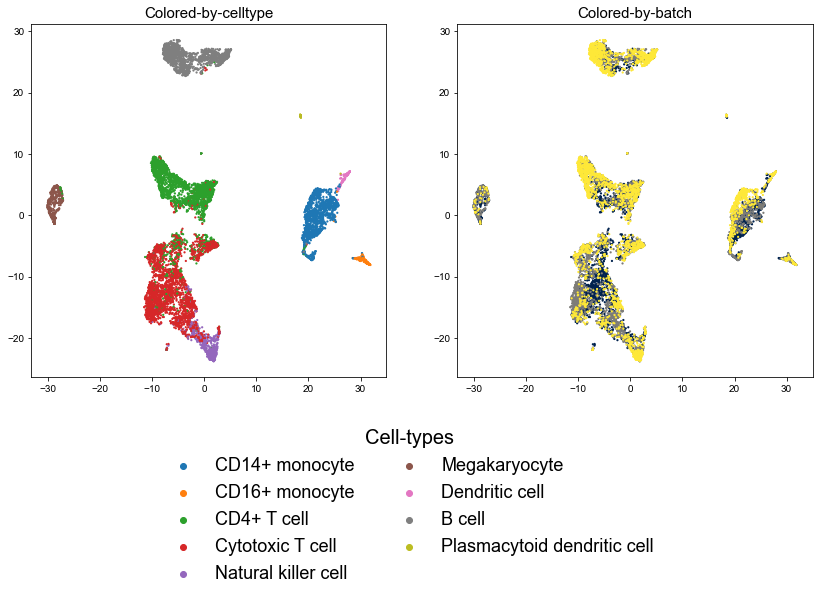

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.


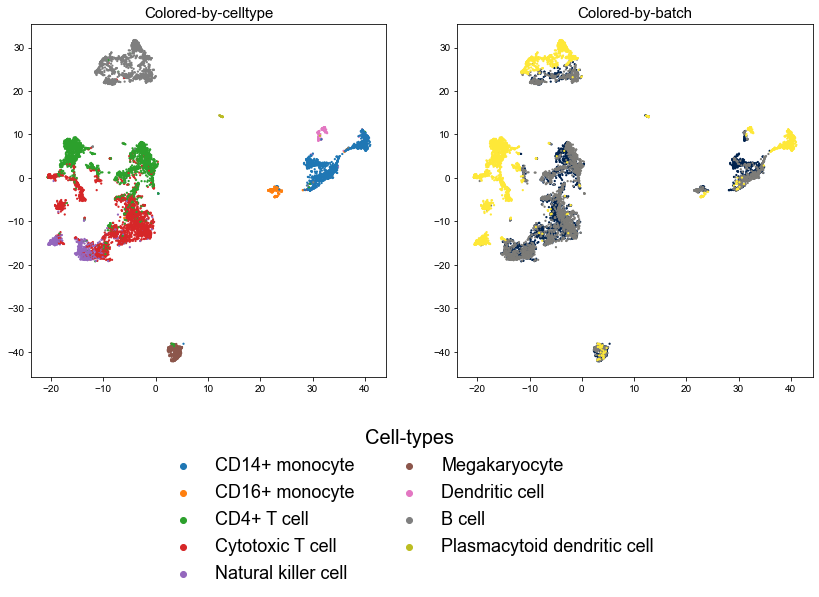

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.


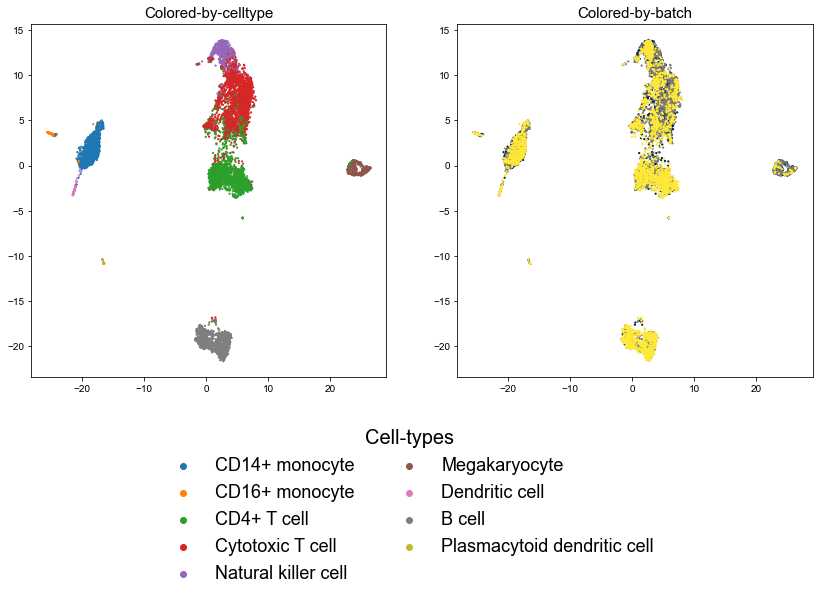

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.


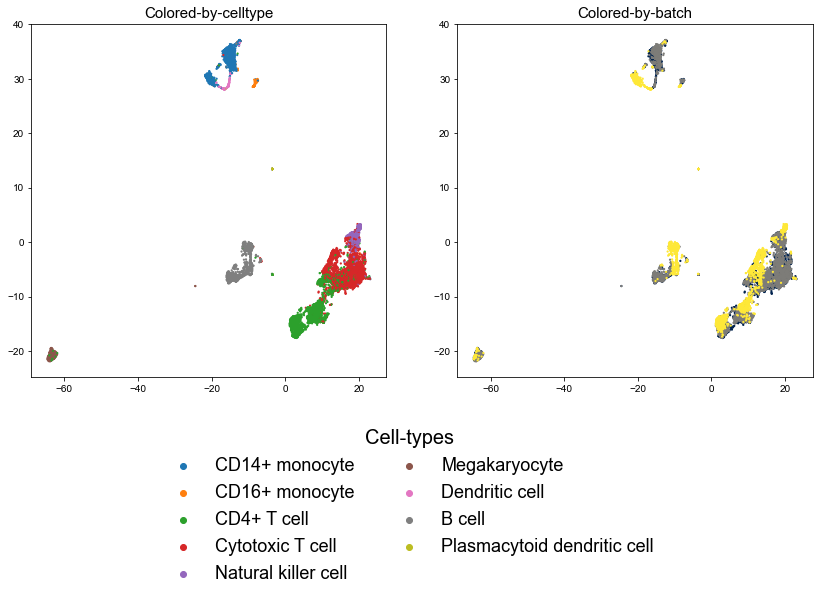

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.


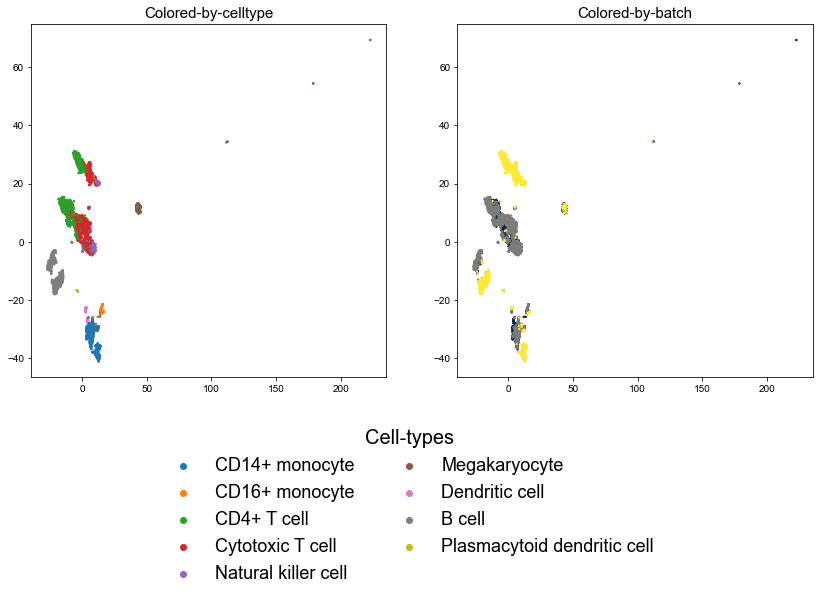

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.


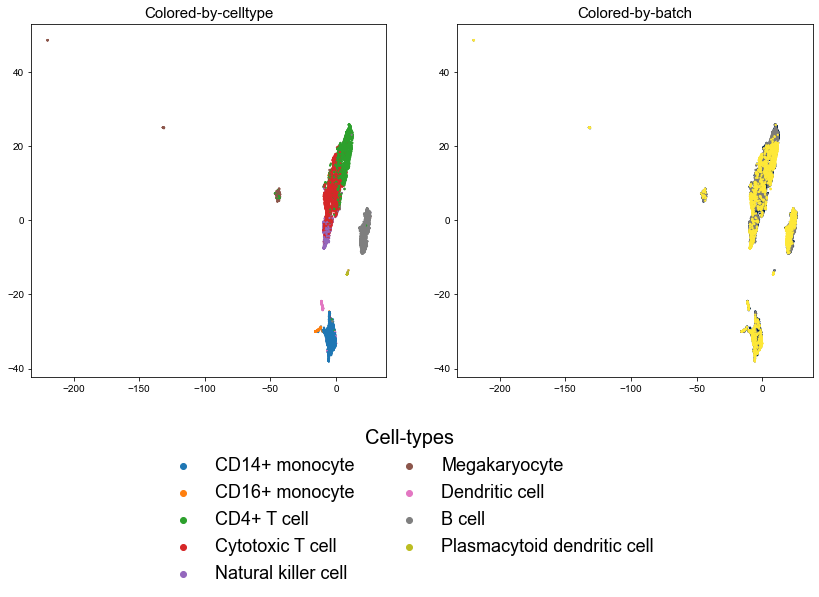

In [16]:
tsne_logpca = tsne_for_pca(pca_logpca)
tsne_sct = tsne_for_pca(pca_sct)
tsne_harmony = tsne_for_pca(pca_harmony)
tsne_glmpca = tsne_for_pca(pca_glmpca)
tsne_ap = tsne_for_pca(pca_ap)
tsne_fr = tsne_for_pca(pca_fr)

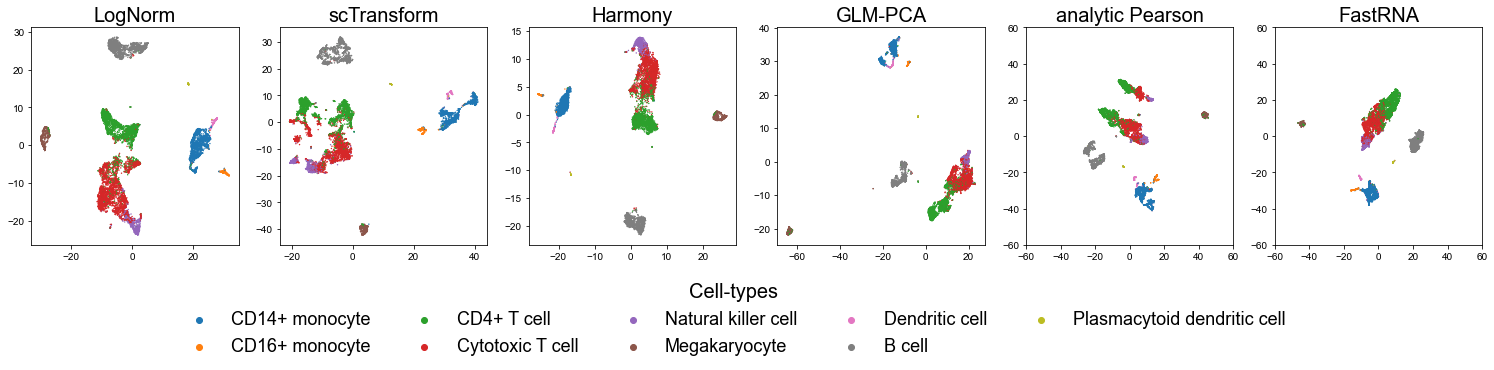

In [17]:
fig, ax = plt.subplots(1, 6, figsize=(26, 4))
np.random.seed(0)

scatter = sns.scatterplot(x=tsne_logpca[:,0], y=tsne_logpca[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=True,
                ax=ax[0],
                palette='tab10', rasterized=True
                )

sns.scatterplot(x=tsne_sct[:,0], y=tsne_sct[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[1],
                palette='tab10', rasterized=True
                )

sns.scatterplot(x=tsne_harmony[:,0], y=tsne_harmony[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[2],
                palette='tab10', rasterized=True
                )

sns.scatterplot(x=tsne_glmpca[:,0], y=tsne_glmpca[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[3],
                palette='tab10', rasterized=True
                )

sns.scatterplot(x=tsne_ap[:,0], y=tsne_ap[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[4],
                palette='tab10', rasterized=True
                )

sns.scatterplot(x=tsne_fr[:,0], y=tsne_fr[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[5],
                palette='tab10', rasterized=True
                )

ax[0].legend().set_visible(False)

handles0, labels0 = ax[0].get_legend_handles_labels()
legend = fig.legend(handles0, 
           labels0, 
           bbox_to_anchor=(0.5,0.05), 
           loc='upper center', 
           ncol=5, 
           fontsize=18, 
           frameon=False)

legend.set_title('Cell-types', prop={'size':20})

labels = ['LogNorm', 'scTransform', 'Harmony', 'GLM-PCA', 'analytic Pearson', 'FastRNA']
for _ax, _label in zip(ax, labels):
    _ax.set_title(_label, fontsize=20)
    if _label in ['analytic Pearson', 'FastRNA']:
        _ax.set_ylim([-60,60])
        _ax.set_xlim([-60,60])

plt.show()

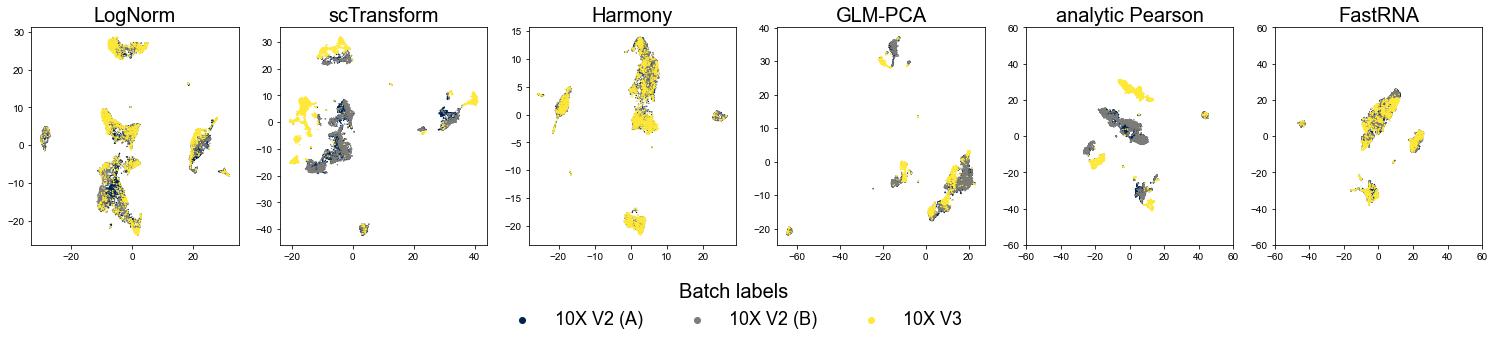

In [18]:
fig, ax = plt.subplots(1, 6, figsize=(26, 4))
np.random.seed(0)

scatter = sns.scatterplot(x=tsne_logpca[:,0], y=tsne_logpca[:,1], 
                s=2, 
                hue=blab_reorder, 
                edgecolor='none', 
                legend=True,
                ax=ax[0],
                palette='cividis', rasterized=True
                )

sns.scatterplot(x=tsne_sct[:,0], y=tsne_sct[:,1], 
                s=2, 
                hue=blab_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[1],
                palette='cividis', rasterized=True
                )

sns.scatterplot(x=tsne_harmony[:,0], y=tsne_harmony[:,1], 
                s=2, 
                hue=blab_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[2],
                palette='cividis', rasterized=True
                )

sns.scatterplot(x=tsne_glmpca[:,0], y=tsne_glmpca[:,1], 
                s=2, 
                hue=blab_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[3],
                palette='cividis', rasterized=True
                )

sns.scatterplot(x=tsne_ap[:,0], y=tsne_ap[:,1], 
                s=2, 
                hue=blab_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[4],
                palette='cividis', rasterized=True
                )

sns.scatterplot(x=tsne_fr[:,0], y=tsne_fr[:,1], 
                s=2, 
                hue=blab_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[5],
                palette='cividis', rasterized=True
                )

ax[0].legend().set_visible(False)

handles0, labels0 = ax[0].get_legend_handles_labels()
legend = fig.legend(handles0, 
           ['10X V2 (A)', '10X V2 (B)', '10X V3'], 
           bbox_to_anchor=(0.5,0.05), 
           loc='upper center', 
           ncol=4, 
           fontsize=18, 
           frameon=False)

legend.set_title('Batch labels', prop={'size':20})

labels = ['LogNorm', 'scTransform', 'Harmony', 'GLM-PCA', 'analytic Pearson', 'FastRNA']
for _ax, _label in zip(ax, labels):
    _ax.set_title(_label, fontsize=20)
    if _label in ['analytic Pearson', 'FastRNA']:
        _ax.set_ylim([-60,60])
        _ax.set_xlim([-60,60])

plt.show()